# All the parameters that need to be changed

In [1]:
# Montana
state_ab = "mt"

## Data
1. Download all the data in directory "mt_data"
2. Eextract them all

In [2]:
data_folder = state_ab + "_data/"
population1_data = "./{}{}_pl2020_b/{}_pl2020_p1_b.shp".format(data_folder, state_ab, state_ab)
population2_data = "./{}{}_pl2020_b/{}_pl2020_p2_b.shp".format(data_folder, state_ab, state_ab)
vap_data =  "./{}{}_pl2020_b/{}_pl2020_p4_b.shp".format(data_folder, state_ab, state_ab)
vest20_data = "./{}{}_vest_20/{}_vest_20.shp".format(data_folder, state_ab, state_ab)
vest18_data = "./{}{}_vest_18/{}_vest_18.shp".format(data_folder, state_ab, state_ab)
vest16_data = "./{}{}_vest_16/{}_vest_16.shp".format(data_folder, state_ab, state_ab)
cd_data = "./{}{}_cong_2021/mt_cong_2021.shp".format(data_folder, state_ab)
send_data = "./{}{}_sldu_adopted_2023/Final_Senate_Districts_2023 2023-02-20/Final_SenateDistricts_Errate_02_23_2023 2023-02-23.shp".format(data_folder, state_ab)
hdist_data = "./{}{}_sldl_adopted_2023/Final_House_Districts_2023 2023-02-20/Final_HouseDistricts_Errata_02_23_2023 2023-02-23.shp".format(data_folder, state_ab)
county_data = "./{}{}_pl2020_cnty/{}_pl2020_cnty.shp".format(data_folder, state_ab, state_ab)

## Parameters that needs to be manually checked

### base vest data
start_col = 5\
vest_base_data = vest20\
year = '20'

### district data
district column name of cong_df, send, hdist when calling add_dist()

# Program starts

In [3]:
import pandas as pd
import geopandas as gpd
import maup
import time
from maup import smart_repair
from gerrychain import Graph
import os

maup.progress.enabled = True

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
def do_smart_repair(df, min_rook_length = None, snap_precision = 10):
    # change it to the UTM it needs for smart_repair
    df = df.to_crs(df.estimate_utm_crs())
    df = smart_repair(df, min_rook_length = min_rook_length, snap_precision = snap_precision)

    if maup.doctor(df) == False:
        raise Exception('maup.doctor failed')
    
    return df

In [6]:
def add_district(dist_df, dist_name, election_df, col_name):
    election_df = election_df.to_crs(election_df.estimate_utm_crs())
    dist_df = dist_df.to_crs(dist_df.estimate_utm_crs())
    # check if it needs to be smart_repair
    if maup.doctor(dist_df) != True:
        dist_df = do_smart_repair(dist_df)

    # assigne the pricincts
    precincts_to_district_assignment = maup.assign(election_df.geometry, dist_df.geometry)
    election_df[dist_name] = precincts_to_district_assignment
    for precinct_index in range(len(election_df)):
        election_df.at[precinct_index, dist_name] = dist_df.at[election_df.at[precinct_index, dist_name], col_name]

    return election_df

In [7]:
def rename(original, year):
    party = original[6]
    if party == 'R' or party == 'D':
        return original[3:6] + year + original[6]
    else:
        return original[3:6] + year + 'O'

In [8]:
def check_population(population, df):
    pop_check = pd.DataFrame({
        'pop_col': pop_col,
        'population_df': population[pop_col].sum(), 
        'vest_base': df[pop_col].sum(),
        'equal': [x == y for x, y in zip(population[pop_col].sum(), df[pop_col].sum())]
    })
    if pop_check['equal'].mean() < 1:
        print(pop_check)
        raise Exception("population doesn't agree")

    else:
        print("population agrees")

In [9]:
def add_vest(vest, df, year, population, start_col, snap_precision = 10):
    df = df.to_crs(df.estimate_utm_crs())
    vest = vest.to_crs(vest.estimate_utm_crs())
    population = population.to_crs(population.estimate_utm_crs())
    df_crs = df.crs
    vest_crs = vest.crs

     # check if it needs to be smart_repair
    if maup.doctor(vest) != True:
        vest = do_smart_repair(vest, snap_precision = snap_precision)
    
    # rename the columns
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum() # combine all the other party's vote into columns with sufix "O"
    col_name = list(set(new_col))
    col_name.sort()
    
    # make the blocks from precincts by weight
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)
    election_in_block = population[["VAP", 'geometry']] # population_df is in block scale
    blocks_to_precincts_assignment = maup.assign(election_in_block.geometry, vest.geometry)
    weights = election_in_block["VAP"] / blocks_to_precincts_assignment.map(election_in_block["VAP"].groupby(blocks_to_precincts_assignment).sum())
    weights = weights.fillna(0)
    prorated = maup.prorate(blocks_to_precincts_assignment, vest[col_name], weights)
    election_in_block[col_name] = prorated
    
    # assign blocks to precincts
    election_in_block = gpd.GeoDataFrame(election_in_block, crs=vest_crs)
    df = gpd.GeoDataFrame(df, crs=df_crs)
    block_to_pricinct_assginment = maup.assign(election_in_block.geometry, df.geometry)
    df[col_name] = election_in_block[col_name].groupby(block_to_pricinct_assginment).sum()
    df = df.groupby(level=0, axis=1).sum()
    df = gpd.GeoDataFrame(df, crs = df_crs)
    # check if population agrees
    check_population(population, df)
    
    return df

In [10]:
def add_vest_base(vest, start_col, year, county = None, min_rook_length = None, snap_precision = 10):
    vest = vest.to_crs(vest.estimate_utm_crs())
    vest_crs = vest.crs
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum()
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)

    if county is not None:
        county = county.to_crs(county.estimate_utm_crs())
        vest = smart_repair(vest, nest_within_regions = county, min_rook_length = min_rook_length, snap_precision = snap_precision) # nest precincts within counties

    else:
        vest = smart_repair(vest, min_rook_length = min_rook_length, snap_precision = snap_precision) 
    
    return vest

In [11]:
def check_small_boundary_lengths(vest_base):
    import copy
    vest_base = vest_base.to_crs(vest_base.estimate_utm_crs())

    boundaries = copy.deepcopy(vest_base)
    boundaries["geometry"] = boundaries.geometry.boundary  # get boundaries
    neighbors = gpd.sjoin(boundaries, vest_base, predicate="intersects") # find boundaries that intersect
    neighbors = neighbors[neighbors.index != neighbors.index_right] # remove boundaries of a region with itself

    # compute shared border length using intersection
    borders = list(neighbors.apply(
        lambda row: row.geometry.intersection(vest_base.loc[row.index_right, "geometry"]).length, axis=1
    ))

    borders.sort()
    
    return borders

## Read the census data

In [12]:
population1_df = gpd.read_file(population1_data)
population2_df = gpd.read_file(population2_data)
vap_df = gpd.read_file(vap_data)
county_df = gpd.read_file(county_data)

In [13]:
population2_df = population2_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])
vap_df = vap_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])

In [14]:
population_df = pd.merge(population1_df, population2_df, on='GEOID20')
population_df = pd.merge(population_df, vap_df, on='GEOID20')
population_df = population_df.to_crs(population_df.estimate_utm_crs())

In [15]:
maup.doctor(population_df)

100%|██████████████████████████████████████████████████████████████| 88417/88417 [00:57<00:00, 1528.16it/s]


True

In [16]:
rename_dict = {'P0020001': 'TOTPOP', 'P0020002': 'HISP', 'P0020005': 'NH_WHITE', 'P0020006': 'NH_BLACK', 'P0020007': 'NH_AMIN',
               'P0020008': 'NH_ASIAN', 'P0020009': 'NH_NHPI', 'P0020010': 'NH_OTHER', 'P0020011': 'NH_2MORE',
               'P0040001': 'VAP', 'P0040002': 'HVAP', 'P0040005': 'WVAP', 'P0040006': 'BVAP', 'P0040007': 'AMINVAP',
               'P0040008': 'ASIANVAP', 'P0040009': 'NHPIVAP', 'P0040010': 'OTHERVAP', 'P0040011': '2MOREVAP'}

In [17]:
population_df.rename(columns=rename_dict, inplace = True)

In [18]:
population_df['H_WHITE'] = population_df.apply(lambda t: t['P0010003'] - t['NH_WHITE'], 1)
population_df['H_BLACK'] = population_df.apply(lambda t: t['P0010004'] - t['NH_BLACK'], 1)
population_df['H_AMIN'] = population_df.apply(lambda t: t['P0010005'] - t['NH_AMIN'], 1)
population_df['H_ASIAN'] = population_df.apply(lambda t: t['P0010006'] - t['NH_ASIAN'], 1)
population_df['H_NHPI'] = population_df.apply(lambda t: t['P0010007'] - t['NH_NHPI'], 1)
population_df['H_OTHER'] = population_df.apply(lambda t: t['P0010008'] - t['NH_OTHER'], 1)
population_df['H_2MORE'] = population_df.apply(lambda t: t['P0010009'] - t['NH_2MORE'], 1)

Make sure that the County shapefile is clean:

In [19]:
maup.doctor(county_df)

100%|█████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 180.01it/s]


True

# Read the base vest data
Now using it as a "base precinct", but it could be vest 18 or vest 16 if vest 20 is not working

### Check if vest 20 can be used as base

In [20]:
vest20 = gpd.read_file(vest20_data)

In [21]:
vest20.columns

Index(['STATEFP10', 'COUNTYFP10', 'COUNTY', 'NAME', 'SOSPRECINC', 'G20PRERTRU',
       'G20PREDBID', 'G20PRELJOR', 'G20USSRDAI', 'G20USSDBUL', 'G20HALRROS',
       'G20HALDWIL', 'G20GOVRGIA', 'G20GOVDCOO', 'G20GOVLBIS', 'G20ATGRKNU',
       'G20ATGDGRA', 'G20SOSRJAC', 'G20SOSDBEN', 'G20AUDRDOW', 'G20AUDDMOR',
       'G20AUDLROO', 'G20SPIRARN', 'G20SPIDROM', 'G20SPILLEA', 'geometry'],
      dtype='object')

## Parameters that need to be checked

In [22]:
start_col = 5
vest_base_data = vest20
year = '20'

In [23]:
# vest_base = add_vest_base(vest20, county_df, start_col, year)
vest_base = add_vest_base(vest20, start_col, year, county = county_df)

100%|█████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 183.33it/s]


Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.


100%|██████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 58.96it/s]


Identifying overlaps...


100%|███████████████████████████████████████████████████████████████| 50802/50802 [00:52<00:00, 970.73it/s]


Resolving overlaps and filling gaps...


Gaps to simplify in region 7: 100%|██████████████████████████████████████| 110/110 [00:01<00:00, 73.14it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 16: 100%|█████████████████████████████████████| 142/142 [00:01<00:00, 73.13it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 25: 100%|█████████████████████████████████████| 101/101 [00:01<00:00, 50.54it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 33: 100%|███████████████████████████████████| 1265/1265 [01:04<00:00, 19.55it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 34: 100%|█████████████████████████████████████| 583/583 [00:20<00:00, 29.11it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 37: 100%|█████████████████████████████████████| 145/145 [00:02<00:00, 51.29it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 43: 100%|███████████████████████████████████| 1664/1664 [01:38<00:00, 16.90it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to fill 

Let's look at the border lengths.  If there's a clear reasonable cutoff for switching rook adjacencies to queen, we use that.  Otherwise, we can use 30.5 m (which is approximately 100 ft).  This is not a magic number, just a reasonable one.

In [24]:
borders = check_small_boundary_lengths(vest_base)
print(borders[:1700])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.612701395071634, 2.612701395071634, 3.145981353690254, 3.145981353690254, 3.2945745224520953, 3.2945745224520953, 3.6332067285916136, 3.6332067285916136, 7.38165281783661, 7.38165281783661, 8.13334885919858, 8.13334885919858, 10.407707396746142, 10.407707396746142, 10.66851134986606, 10.66851134986606, 16.225505042085796, 16.225505042085796, 17.586991162502972, 17.586991162502972, 17.846058301398788, 17.846058301398788, 19.002007526137717, 19.002007526137717, 26.

It's not clear what the cutoff should be here; let's use 30.5.

In [25]:
vest_base = do_smart_repair(vest_base, min_rook_length = 30.5)

Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|██████████████████████████████████████████████████████████████████| 773/773 [00:00<00:00, 1361.29it/s]


Resolving overlaps...
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


Converting small rook adjacencies to queen...


100%|███████████████████████████████████████████████████████████████████| 666/666 [00:02<00:00, 222.67it/s]


In [26]:
maup.doctor(vest_base)

100%|███████████████████████████████████████████████████████████████████| 666/666 [00:01<00:00, 557.82it/s]


True

If it is true for maup doctor, we will use it as the base vest data.

In [27]:
# vap and population have the same GEOID20
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

100%|████████████████████████████████████████████████████████████████████| 666/666 [00:08<00:00, 74.72it/s]


In [28]:
pop_col = ['TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP']

In [29]:
vest_base[pop_col] = population_df[pop_col].groupby(blocks_to_precincts_assignment).sum()

In [30]:
# election_df = gpd.GeoDataFrame(vest_base, crs="EPSG:4269")
election_df = gpd.GeoDataFrame(vest_base)

In [31]:
election_df.columns

Index(['ATG20D', 'ATG20R', 'AUD20D', 'AUD20O', 'AUD20R', 'COUNTY',
       'COUNTYFP10', 'GOV20D', 'GOV20O', 'GOV20R', 'HAL20D', 'HAL20R', 'NAME',
       'PRE20D', 'PRE20O', 'PRE20R', 'SOS20D', 'SOS20R', 'SOSPRECINC',
       'SPI20D', 'SPI20O', 'SPI20R', 'STATEFP10', 'USS20D', 'USS20R',
       'geometry', 'TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN',
       'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK',
       'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP',
       'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP',
       '2MOREVAP'],
      dtype='object')

### Check if the population agrees

In [32]:
check_population(population_df, vest_base)

population agrees


# Add more vest data

In [33]:
vest18 = gpd.read_file(vest18_data)

In [34]:
vest18.columns

Index(['STATEFP10', 'COUNTYFP10', 'COUNTY', 'NAME', 'SOSPRECINC', 'G18USSRROS',
       'G18USSDTES', 'G18USSLBRE', 'G18HALRGIA', 'G18HALDWIL', 'G18HALLSWA',
       'G18CSCRGRE', 'G18CSCDREN', 'G18CSCLROO', 'geometry'],
      dtype='object')

In [35]:
# check the result here
start_col = 5
election_df = add_vest(vest18, election_df, '18', population_df, start_col)

100%|███████████████████████████████████████████████████████████████████| 672/672 [00:01<00:00, 566.17it/s]


There are 1 overlaps.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|██████████████████████████████████████████████████████████████████| 781/781 [00:00<00:00, 2796.26it/s]


Resolving overlaps...
Assigning order 2 pieces...
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████| 666/666 [00:08<00:00, 75.40it/s]


population agrees


### vest 16

In [36]:
vest16 = gpd.read_file(vest16_data)
vest16.columns

Index(['STATEFP10', 'COUNTYFP10', 'COUNTY', 'NAME', 'SOSPRECINC', 'G16PRERTRU',
       'G16PREDCLI', 'G16PRELJOH', 'G16PREGSTE', 'G16PREOFUE', 'G16HALRZIN',
       'G16HALDJUN', 'G16HALLBRE', 'G16GOVRGIA', 'G16GOVDBUL', 'G16GOVLDUN',
       'G16ATGRFOX', 'G16ATGDJEN', 'G16SOSRSTA', 'G16SOSDLIN', 'G16SOSLROO',
       'G16AUDRROS', 'G16AUDDLAS', 'G16SPIRARN', 'G16SPIDROM', 'geometry'],
      dtype='object')

In [37]:
start_col = 5
election_df = add_vest(vest16, election_df, '16', population_df, start_col)

100%|███████████████████████████████████████████████████████████████████| 689/689 [00:02<00:00, 293.60it/s]


There are 7 overlaps.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|██████████████████████████████████████████████████████████████████| 812/812 [00:00<00:00, 2347.91it/s]


Resolving overlaps...
Assigning order 2 pieces...
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████| 666/666 [00:08<00:00, 77.77it/s]


population agrees


## Add the district data

In [38]:
cong_df = gpd.read_file(cd_data)
cong_df = cong_df.to_crs(cong_df.estimate_utm_crs())
send = gpd.read_file(send_data)
send = send.to_crs(send.estimate_utm_crs())
hdist = gpd.read_file(hdist_data)
hdist = hdist.to_crs(hdist.estimate_utm_crs())

In [39]:
cong_df.head()

,ID,geometry
0,1,"POLYGON ((496448.169 4983056.921, 496409.156 4..."
1,2,"POLYGON ((350088.473 5332827.045, 351262.082 5..."


In [40]:
send.head()

,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,ADJ_POPULA,ADJSUP_AMI,ADJSUP_BLA,ADJSUP_ASI,...,DEVIATION,F_DEVIATIO,F_ADJSUP_A,F_ADJSUP_1,F_ADJSUP_2,F_ADJSUP_B,F_ADJSUP_3,F_ADJSUP_N,DISTRICT_L,geometry
0,2,4203.362305,1,1.0,None,SD01,21727,246,38,116,...,73.0,0.003371,0.011322,0.810742,0.011297,0.001749,0.005339,0.899296,1|0.34%,"POLYGON ((227423.608 5434208.227, 227397.041 5..."
1,5,2238.900146,2,1.0,None,SD02,21538,187,58,119,...,-116.0,-0.005357,0.008682,0.805785,0.009046,0.002693,0.005525,0.897762,2|-0.54%,"POLYGON ((273895.630 5373287.798, 273886.603 5..."
2,8,450.303955,3,1.0,None,SD03,21853,176,47,124,...,199.0,0.009190,0.008054,0.774402,0.007564,0.002151,0.005674,0.900426,3|0.92%,"POLYGON ((214229.864 5348595.517, 214250.244 5..."
3,11,14.699925,4,1.0,None,SD04,21463,303,77,213,...,-191.0,-0.008821,0.014117,0.779481,0.014226,0.003588,0.009924,0.878069,4|-0.88%,"POLYGON ((253122.094 5346267.069, 253127.802 5..."
4,14,316.578522,5,1.0,None,SD05,21696,189,66,170,...,42.0,0.001940,0.008711,0.762168,0.008648,0.003042,0.007836,0.897032,5|0.19%,"POLYGON ((238275.690 5347425.819, 238288.530 5..."


In [41]:
hdist.head()

,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,ADJ_POPULA,ADJSUP_POP,ADJSUP_NH_,ADJSUP_BLA,...,F_ADJSUP_B,F_ADJSUP_A,F_ADJSUP_1,F_ADJSUP_H,F_ADJSUP_2,DEVIATION,F_ADJSUP_3,DISTRICT_N,DISTRICT_L,geometry
0,1,5937.892578,29,1.0,None,029,10911,10911,9553,24,...,0.002200,0.040510,0.004033,0.026212,0.778755,84.0,0.033541,29,29|0.78%,"POLYGON ((824891.649 5346874.136, 824854.762 5..."
1,2,3493.946289,31,1.0,None,031,10304,10304,2557,28,...,0.002717,0.671099,0.004464,0.021351,0.690120,-523.0,0.618619,31,31|-4.83%,"POLYGON ((827387.961 5341586.489, 827462.570 5..."
2,3,5306.041016,32,1.0,None,032,10342,10342,2971,7,...,0.000677,0.669213,0.001064,0.026107,0.662251,-485.0,0.626807,32,32|-4.48%,"POLYGON ((732130.229 5359900.877, 732135.549 5..."
3,4,21.599699,27,1.0,None,027,10731,10731,8041,43,...,0.004007,0.131209,0.007082,0.037368,0.756127,-96.0,0.111412,27,27|-0.89%,"POLYGON ((597329.886 5376016.556, 597317.181 5..."
4,5,9375.785156,28,1.0,None,028,10859,10859,9665,14,...,0.001289,0.039783,0.002855,0.019983,0.768303,32.0,0.031164,28,28|0.3%,"POLYGON ((518793.463 5427332.619, 518794.488 5..."


In [42]:
election_df = add_district(cong_df, "CD", election_df, "ID")

100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.04it/s]


In [43]:
election_df = add_district(send, "SEND", election_df, "ID")

100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 33.80it/s]


In [44]:
election_df = add_district(hdist, "HDIST", election_df, "ID")

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 58.33it/s]


In [45]:
election_df.columns

Index(['2MOREVAP', 'AMINVAP', 'ASIANVAP', 'ATG16D', 'ATG16R', 'ATG20D',
       'ATG20R', 'AUD16D', 'AUD16R', 'AUD20D', 'AUD20O', 'AUD20R', 'BVAP',
       'COUNTY', 'COUNTYFP10', 'CSC18D', 'CSC18O', 'CSC18R', 'GOV16D',
       'GOV16O', 'GOV16R', 'GOV20D', 'GOV20O', 'GOV20R', 'HAL16D', 'HAL16O',
       'HAL16R', 'HAL18D', 'HAL18O', 'HAL18R', 'HAL20D', 'HAL20R', 'HISP',
       'HVAP', 'H_2MORE', 'H_AMIN', 'H_ASIAN', 'H_BLACK', 'H_NHPI', 'H_OTHER',
       'H_WHITE', 'NAME', 'NHPIVAP', 'NH_2MORE', 'NH_AMIN', 'NH_ASIAN',
       'NH_BLACK', 'NH_NHPI', 'NH_OTHER', 'NH_WHITE', 'OTHERVAP', 'PRE16D',
       'PRE16O', 'PRE16R', 'PRE20D', 'PRE20O', 'PRE20R', 'SOS16D', 'SOS16O',
       'SOS16R', 'SOS20D', 'SOS20R', 'SOSPRECINC', 'SPI16D', 'SPI16R',
       'SPI20D', 'SPI20O', 'SPI20R', 'STATEFP10', 'TOTPOP', 'USS18D', 'USS18O',
       'USS18R', 'USS20D', 'USS20R', 'VAP', 'WVAP', 'geometry', 'CD', 'SEND',
       'HDIST'],
      dtype='object')

### Put the base precinct year after the precinct information column

In [46]:
base_columns = {}
if 'COUNTY' + year not in election_df.columns:
    base_columns = {
        'COUNTY':'COUNTY'+year,
        'SOSPRECINC':'SOSPRECINC'+year,
        'COUNTYFP10':'COUNTYFP10'+year,
        'NAME':'NAME'+year,
        'STATEFP10':'STATEFP10'+year
    }
election_df.rename(columns=base_columns, inplace = True)

In [47]:
# reorder the columns
fixed_columns = [
    'COUNTY'+year,
    'COUNTYFP10'+year,
    'NAME'+year,
    'SOSPRECINC'+year,
    'STATEFP10'+year,
    'CD',
    'SEND',
    'HDIST',
    'TOTPOP',
    'NH_2MORE',
    'NH_AMIN',
    'NH_ASIAN',
    'NH_BLACK',
    'NH_NHPI',
    'NH_OTHER',
    'NH_WHITE',
    'HISP',
    'H_AMIN',
    'H_ASIAN',
    'H_BLACK',
    'H_NHPI',
    'H_OTHER',
    'H_WHITE',
    'H_2MORE',
    'VAP',
    'HVAP',
    'WVAP',
    'BVAP',
    'AMINVAP',
    'ASIANVAP',
    'NHPIVAP',
    'OTHERVAP',
    '2MOREVAP']

election_columns = [col for col in election_df.columns if col not in fixed_columns]
final_col = fixed_columns + election_columns
election_df = election_df[final_col]

In [48]:
list(election_df.columns)

['COUNTY20',
 'COUNTYFP1020',
 'NAME20',
 'SOSPRECINC20',
 'STATEFP1020',
 'CD',
 'SEND',
 'HDIST',
 'TOTPOP',
 'NH_2MORE',
 'NH_AMIN',
 'NH_ASIAN',
 'NH_BLACK',
 'NH_NHPI',
 'NH_OTHER',
 'NH_WHITE',
 'HISP',
 'H_AMIN',
 'H_ASIAN',
 'H_BLACK',
 'H_NHPI',
 'H_OTHER',
 'H_WHITE',
 'H_2MORE',
 'VAP',
 'HVAP',
 'WVAP',
 'BVAP',
 'AMINVAP',
 'ASIANVAP',
 'NHPIVAP',
 'OTHERVAP',
 '2MOREVAP',
 'ATG16D',
 'ATG16R',
 'ATG20D',
 'ATG20R',
 'AUD16D',
 'AUD16R',
 'AUD20D',
 'AUD20O',
 'AUD20R',
 'CSC18D',
 'CSC18O',
 'CSC18R',
 'GOV16D',
 'GOV16O',
 'GOV16R',
 'GOV20D',
 'GOV20O',
 'GOV20R',
 'HAL16D',
 'HAL16O',
 'HAL16R',
 'HAL18D',
 'HAL18O',
 'HAL18R',
 'HAL20D',
 'HAL20R',
 'PRE16D',
 'PRE16O',
 'PRE16R',
 'PRE20D',
 'PRE20O',
 'PRE20R',
 'SOS16D',
 'SOS16O',
 'SOS16R',
 'SOS20D',
 'SOS20R',
 'SPI16D',
 'SPI16R',
 'SPI20D',
 'SPI20O',
 'SPI20R',
 'USS18D',
 'USS18O',
 'USS18R',
 'USS20D',
 'USS20R',
 'geometry']

In [49]:
# store the result in directory "mt"
os.makedirs("./{}".format(state_ab), exist_ok=True)
election_df.to_file("./{}/{}.shp".format(state_ab, state_ab))
election_df.to_file('./{}/{}.geojson'.format(state_ab, state_ab), driver='GeoJSON')

# Only do once to build json and read from file when generating ensembles
graph = Graph.from_file("./{}/{}.shp".format(state_ab, state_ab), ignore_errors=True)
graph.to_json("./{}/{}.json".format(state_ab, state_ab))

<Axes: >

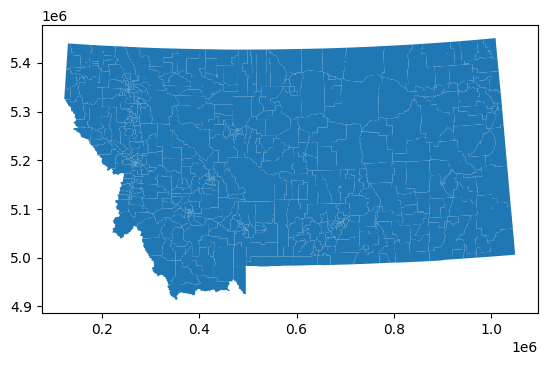

In [50]:
shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
shape=gpd.read_file(shapefile_path)
shape.plot()